## **Importing Libraries**

A library was built with the name tfqml.py to store all the dependencies, classes and methods that are used in this work, these classes are
- ClassicalPreprocessing,

together with the methods 
- visualization and 
- save_data


the dependencies are:
- numpy 
- pandas 
- matplotlib
- sklearn
- tensorflow
- pennylane

In [1]:
from tfqml import *
import pennylane as qml

2022-02-25 02:34:02.460452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 02:34:02.490385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 02:34:02.490617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 02:34:02.491244: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## **Choose the 8 stocks**

we select 8 stocks from 8 conglomerates based on the dataset of Xu et al. [[2]](https://aclanthology.org/P18-1183/): 

- Basic Materials: TOTAL S.A. "TOT"

- Consumer Goods: Appel Inc. "AAPL"

- Healthcare: AbbVie Inc. "ABBV"

- Services: Wall-Mart Stores Inc. "WMT"

- Utilites: Duke energy corporation "DUK"

- Financial: HSBS Holding pcl "HSBC"

- Industrial Goods: ABB Ltd. "ABB"

- Technology: China Mobile Limited "CHL"

In [2]:
name_stocks = ['AAPL','ABB','ABBV','TOT','WMT','DUK','CHL','HSBC']

# Classical Preprocessing

The methods of our library are used to preprocess the csv files of the 8 stocks,
We consider 30 days por each instance and we obtain the shape of the train and test dataset

In [3]:
index = 2

In [4]:
cp = ClassicalPreprocessing(filename=name_stocks[index])
days = 30
x_train,y_train,x_test,y_test = cp.preprocessing(days=days,flag_pca=True)

Shape of train data: (823, 1)
Shape of test data: (354, 1)


# Quantum Pre processing

Convert the classical information fo the train and test dataset into a quantumcircuit this is possible using cirq, for this proposal we consider two encoding method, amplitude and angle, we keep the last one, for its result it was very well with respect the amplitude. Using as reference this the paper [Quantum Long Short-Term Memory](https://arxiv.org/pdf/2009.01783.pdf)  for the encoding, is important apply the arctang of the data and add a proposal. It was proposed for this encoding to reduce the number of qubits with the consideration that there are 30 data, one for each of the 3 coordinates, therefore the number of days divided by 3 will have to be used, it should be noted that data of multiples of 3 are needed to use this encoding.

In [5]:
n_qubits = days//3

dev = qml.device("default.qubit.tf", wires=n_qubits) # using backend tensorflow


#quantum circuit for the encoding and ansayz

@qml.qnode(dev)
def qnode(inputs,weights_0,weights_1,weights_2,weights_3):#structure to use mennylane with tensorflow
    for i in range(10):
        qml.RY(np.arctan(inputs[i]),wires=i) #first 10 inputs apply in ry
        qml.Hadamard(i)
        qml.RX(np.arctan(inputs[10+i]),wires=i) #the 10-20 inputs apply in rx
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[4, 5])
    qml.CNOT(wires=[6, 7])
    qml.CNOT(wires=[8, 9])
    for i in range(10): 
        qml.RZ(np.arctan(inputs[20+i]),wires=i) #the 20-30 inputs apply in rz
    
    
    #ansatz
    for j,w in enumerate(weights_0): #weights
        qml.RY(w, wires=j)   #apply a layer of ry
        

    # apply different cnots between the ansatz
    qml.CNOT(wires=[0, 1])
    
    qml.CNOT(wires=[4, 3])
    
    qml.CNOT(wires=[3, 2])    
    
    qml.CNOT(wires=[2, 1])
    
    
    #apply RY and Hadamard with the target output of each cx
    list_index = [1,3,5,7,9]
    for j,w in enumerate(weights_1):
        qml.RY(w, wires=list_index[j])      
        

    qml.Hadamard(1)
    qml.Hadamard(3)
    qml.Hadamard(5)
    qml.Hadamard(7)
    qml.Hadamard(9)
    
    # repeat the same ansatz using RX in stead of RY
    for j,w in enumerate(weights_2):
        qml.RX(w, wires=j)
    
    qml.CNOT(wires=[0, 1])
    
    qml.CNOT(wires=[4, 3])
    
    qml.CNOT(wires=[3, 2])    
    
    qml.CNOT(wires=[2, 1])
    
    list_index = [1,3,5,7,9]
    for j,w in enumerate(weights_3):
        qml.RX(w, wires=list_index[j])     
        
    qml.Hadamard(1)
    qml.Hadamard(3)
    qml.Hadamard(5)
    qml.Hadamard(7)
    qml.Hadamard(9)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3)), qml.expval(qml.PauliZ(4)),qml.expval(qml.PauliZ(5)), qml.expval(qml.PauliZ(6)), qml.expval(qml.PauliZ(7)), qml.expval(qml.PauliZ(8)), qml.expval(qml.PauliZ(9))
        
weight_shapes = {"weights_0": 10, "weights_1": 5, "weights_2": 10, "weights_3": 5}#,"weights_5": 1,"weights_6": 1,"weights_7": 1,"weights_8": 1,"weights_9": 1}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=10)

Creating our LSTM hibryd model.The first layer is our proposal which input is 30 parameters per instance and output is 10, followed by LSTM and Dropout layers, at the end a Dense layer to have an output value.


In [6]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=()))

model.add(qlayer)
model.add(tf.keras.layers.Reshape((1,10)))
model.add(tf.keras.layers.LSTM(units=100, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=100, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=5))
model.add(tf.keras.layers.Dense(units=1))

Apply the as loss the MSE and optimizer ADAM

In [7]:
model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.build()

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 10)                0 (unused)
                                                                 
 reshape (Reshape)           (None, 1, 10)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 100)            44400     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 5)                 2

Consider only 60 epoch with a batch size of 32

In [9]:
qnn_history = model.fit(
      tf.constant(x_train), y_train,
      batch_size=32,
      epochs=60)

qnn_results = model.evaluate(tf.constant(x_test), y_test)



Epoch 1/60


2022-02-25 02:34:20.894423: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202
2022-02-25 02:34:21.027682: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


25/25 [==============================] - 133s 5s/step - loss: 0.3040 - root_mean_squared_error: 0.5513
Epoch 2/60
25/25 [==============================] - 131s 5s/step - loss: 0.0987 - root_mean_squared_error: 0.3142
Epoch 3/60
25/25 [==============================] - 130s 5s/step - loss: 0.0509 - root_mean_squared_error: 0.2257
Epoch 4/60
25/25 [==============================] - 129s 5s/step - loss: 0.0430 - root_mean_squared_error: 0.2074
Epoch 5/60
25/25 [==============================] - 129s 5s/step - loss: 0.0380 - root_mean_squared_error: 0.1949
Epoch 6/60
25/25 [==============================] - 132s 5s/step - loss: 0.0283 - root_mean_squared_error: 0.1682
Epoch 7/60
25/25 [==============================] - 132s 5s/step - loss: 0.0187 - root_mean_squared_error: 0.1366
Epoch 8/60
25/25 [==============================] - 131s 5s/step - loss: 0.0095 - root_mean_squared_error: 0.0974
Epoch 9/60
25/25 [==============================] - 129s 5s/step - loss: 0.0063 - root_mean_squared

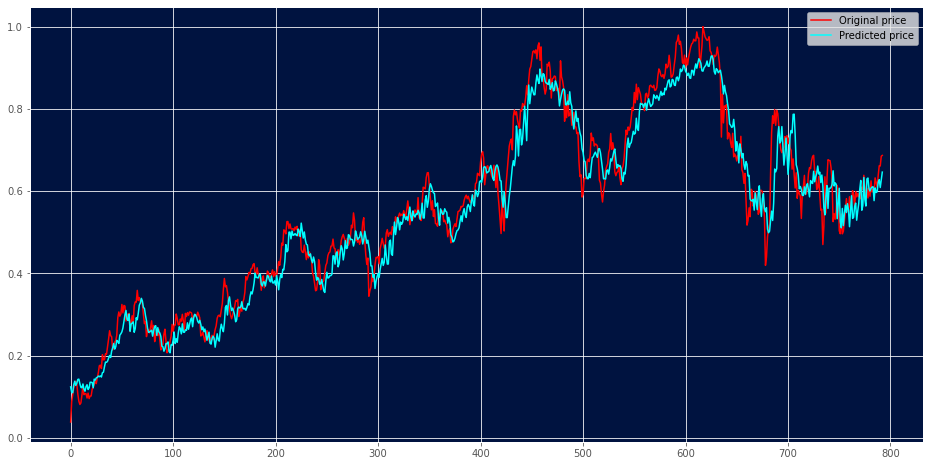

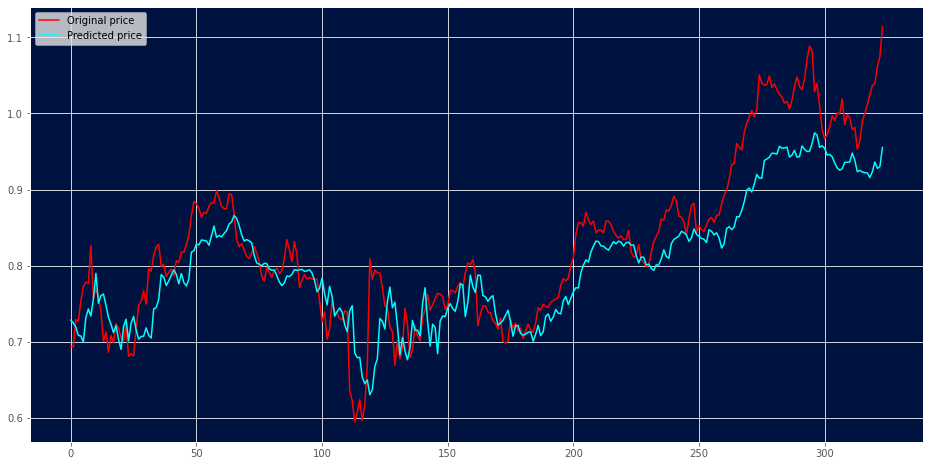

In [10]:
visualization(model,tf.constant(x_train),y_train)
visualization(model,tf.constant(x_test),y_test)

Plot the result between the  real and predict with both data set, train and test.

In [11]:
iteration= 0
save_data(model,x_train,y_train,"pennylane_"+name_stocks[index]+"_"+str(iteration)+"_train")
save_data(model,x_test,y_test,"pennylane_"+name_stocks[index]+"_"+str(iteration)+"_test")


MAE 3.78%
MAE 4.04%
